In [1]:
import random 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from imblearn.over_sampling import SMOTE,BorderlineSMOTE
from sklearn.impute import KNNImputer,SimpleImputer
from sklearn.preprocessing import LabelEncoder,MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split,KFold, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix,auc,roc_curve,classification_report,accuracy_score,make_scorer,recall_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,GradientBoostingClassifier,VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.neural_network import MLPClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from pandas import set_option
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
import warnings
import seaborn as sns

warnings.filterwarnings("ignore")
df = pd.read_csv('uci-secom.csv')
df

,Time,0,1,2,3,4,5,6,7,8,...,581,582,583,584,585,586,587,588,589,Pass/Fail
0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1
1,2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2,2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2008-07-19 14:43:00,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1
4,2008-07-19 15:22:00,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,...,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562,2008-10-16 15:13:00,2899.41,2464.36,2179.7333,3085.3781,1.4843,100.0,82.2467,0.1248,1.3424,...,203.1720,0.4988,0.0143,0.0039,2.8669,0.0068,0.0138,0.0047,203.1720,-1
1563,2008-10-16 20:49:00,3052.31,2522.55,2198.5667,1124.6595,0.8763,100.0,98.4689,0.1205,1.4333,...,NaN,0.4975,0.0131,0.0036,2.6238,0.0068,0.0138,0.0047,203.1720,-1
1564,2008-10-17 05:26:00,2978.81,2379.78,2206.3000,1110.4967,0.8236,100.0,99.4122,0.1208,NaN,...,43.5231,0.4987,0.0153,0.0041,3.0590,0.0197,0.0086,0.0025,43.5231,-1
1565,2008-10-17 06:01:00,2894.92,2532.01,2177.0333,1183.7287,1.5726,100.0,98.7978,0.1213,1.4622,...,93.4941,0.5004,0.0178,0.0038,3.5662,0.0262,0.0245,0.0075,93.4941,-1


In [2]:
df = df.drop(['Time'],axis=1)

## Check missing value

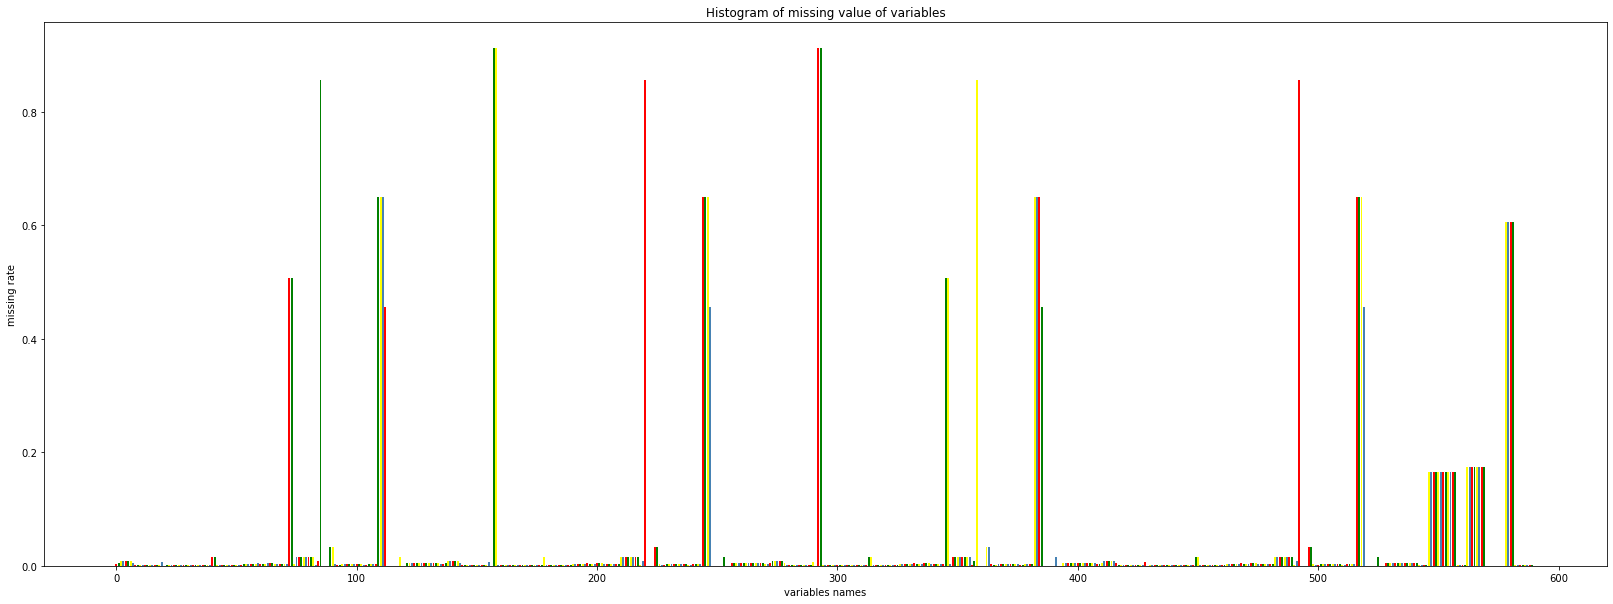

In [3]:
missing= df.isnull().sum().reset_index().rename(columns={0:'missNum'})
missing['missRate']=missing['missNum']/df.shape[0]
fig = plt.figure(figsize=(28,10))
plt.bar(np.arange(missing.shape[0]), list(missing.missRate.values), align = 'center', color = ['red','green','yellow','steelblue'])
plt.title('Histogram of missing value of variables')
plt.xlabel('variables names')
plt.ylabel('missing rate') 
plt.show()

## Remove the feature with more than 90% of null values

In [4]:
empty = missing[missing['missRate']>0.9]['index'].values
df = df.drop(empty,axis=1)
print(df.shape)

(1567, 587)


## Imputation

In [5]:
knn =  KNNImputer(n_neighbors=3)
impute = knn.fit_transform(df)
df_impute = pd.DataFrame(impute, columns = df.columns)

In [6]:
labelencoder = LabelEncoder()
df_impute['Pass/Fail'] = labelencoder.fit_transform(df_impute['Pass/Fail'])
df_feature = df_impute.drop(['Pass/Fail'],axis = 1)
df_label = df_impute['Pass/Fail']

## Examining Class Imbalance

0    1463
1     104
Name: Pass/Fail, dtype: int64


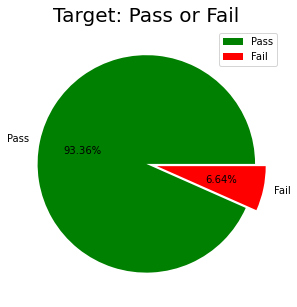

In [7]:
# pie chart
labels = ['Pass', 'Fail']
size = df_label.value_counts()
colors = ['green', 'red']
explode = [0, 0.1]

print(df_label.value_counts())
plt.style.use('seaborn-deep')
plt.rcParams['figure.figsize'] = (5 ,5)
plt.pie(size, labels =labels, colors = colors, explode = explode, autopct = "%.2f%%", shadow = False)
plt.axis('off')
plt.title('Target: Pass or Fail', fontsize = 20)
plt.legend()
plt.show()

## Addressing Outliers
Outliers are identified and replaced by median value of the corresponding feature.

In [8]:
def outliers(df):
    features = df.columns
    for j in features:
        Q1 = df[j].quantile(q=0.25)
        Q2 = df[j].median()
        Q3 = df[j].quantile(q=0.75)
        IQR = Q3 - Q1
        upper_bound = Q3 + 1.5*IQR
        lower_bound = Q1 - 1.5*IQR
        for i in range(0,df.shape[0]):
            if(df[j][i] > upper_bound or df[j][i]<lower_bound):
                df[j][i] = df[j].median() 
    return df

df_feature = outliers(df_feature)

## The Correlation between  Data Feature

Text(0.5, 1.0, 'Correlation heatmap for the Data')

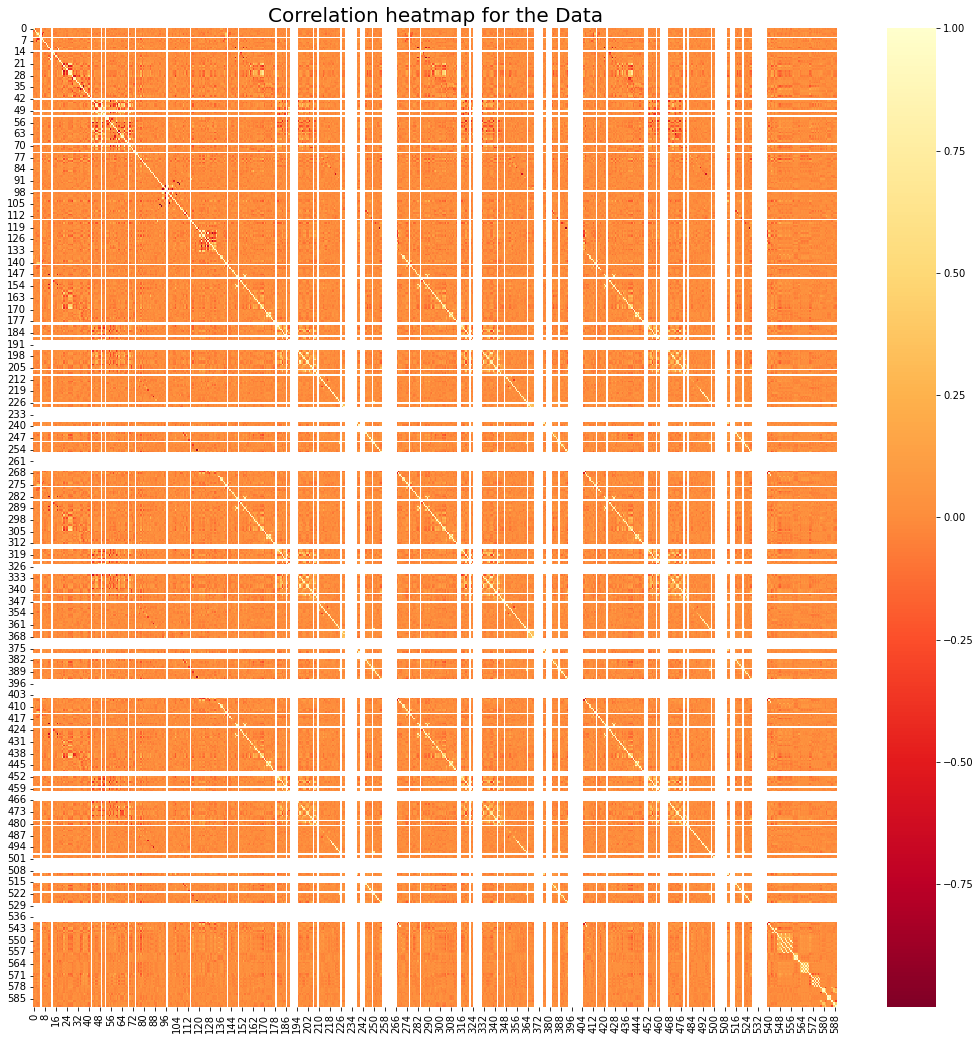

In [19]:
# heatmap to get correlation

plt.rcParams['figure.figsize'] = (18, 18)
sns.heatmap(df_feature.corr(), cmap = 'YlOrRd_r')
plt.title('Correlation heatmap for the Data', fontsize = 20)

## Check Multi-collinearity problem

Checking for **correlated independent** features using correlation matrix. The threshold is selected as 0.80. If two features are correlated by coefficient>0.9, one of the correlated feature is removed.  

In [ ]:
def remove_corr(df, threshold):

    corr = pd.DataFrame(abs(df.corr()))
    
    Featurei = []
    Featurej = []
    Corr = []

    for i in corr.index:
        for j in corr.columns:
            if (corr.loc[i, j] > threshold and i != j):
                if(i not in Featurei):
                    Featurei.append(i)
                if(j not in Featurej):
                    Featurej.append(j)
                    Corr.append(corr.loc[i, j])
    
    d = pd.DataFrame([Featurei, Featurej, Corr]).transpose()
    display(d)
    
    to_drop = set(d[0])
    print('Number of features removed = ', len(to_drop))
    
    return (df.drop(to_drop, axis=1))

df_feature = remove_corr(df_feature, 0.80)

,0,1,2
0,11,147,0.902877
1,12,282,0.904849
2,17,420,0.906577
3,18,18,0.980611
4,21,153,0.891689
...,...,...,...
323,583,584,0.831048
324,584,585,0.996439
325,585,583,0.831048
326,587,588,0.851673


Number of features removed =  328


Checking for **Variance Inflation Factor (VIF)** of each independent feature. Features with VIF>5 are removed.  

The **Variance Inflation Factor (VIF)** is a numerical value that represents the degree of collinearity between observations of an independent variable.  
A VIF greater than 5 is considered multicollinearity.

In [ ]:
def remove_high_VIF(df, limit):
    vif = pd.DataFrame()
    high_vif = []
    vif['features'] = df.columns
    vif['VIF'] = [VIF(df.values,i) for i in range(len(df.columns))]

    high_vif= vif[vif['VIF']>limit].features
    print('Number of features with VIF > ',limit,'= ',len(high_vif))
    return(df.drop(high_vif,axis=1))
    
df_feature = remove_high_VIF(df_feature,5)

Number of features with VIF >  5 =  3


Features with very low variance will not have predicitve power. Thus, features with very low variance are detected and dropped.  
Variance Threshold is calculated as (0.8*(1-0.8)) 

In [ ]:
def remove_variance(df,thres):
    set_option('precision', 3)
    sel = VarianceThreshold(threshold=(thres * (1 - thres)))
    var_df = pd.DataFrame({'Name':df.columns,'Var':sel.fit(df).variances_})    
    dummy = var_df['Name'].where(var_df['Var']<(thres * (1 - thres)))
    dummy = dummy.dropna()
    print('Number of features removed: ',len(dummy))
    return(dummy)

df_feature = df_feature.drop(remove_variance(df_feature,0.80),axis=1)

Number of features removed:  189


## Feature selection

Using XGBoost to further select the best features.

In [ ]:
def imp_features(X, y):
    model = xgb.XGBClassifier()
    model.fit(X,y)
    fi_df = pd.DataFrame({'Name':pd.Series(model.feature_names_in_),
                      'FI':pd.Series(model.feature_importances_)})   
    dummy = fi_df['Name'].where(fi_df['FI']>0.01)
    dummy = dummy.dropna()
    display(fi_df.sort_values(by='FI',ascending=False))
    print('Number of features with ''feature importance'' greater than 0 :',len(dummy))
    return(dummy)
    
imp_features = imp_features(df_feature,df_label) 
df_feature = df_feature[imp_features]

,Name,FI
18,59,0.029
57,500,0.029
56,499,0.027
15,41,0.027
31,129,0.025
...,...,...
19,63,0.006
50,484,0.005
53,487,0.004
63,570,0.002


Number of features with feature importance greater than 0 : 51


### Normalize data

In [ ]:
scaler =  MinMaxScaler()
scaled_feature = scaler.fit_transform(df_feature)
scaled_feature = pd.DataFrame(scaled_feature,columns=df_feature.columns)
scaled_feature

,0,1,2,14,16,22,23,28,32,39,...,486,488,489,499,500,510,547,548,562,581
0,0.555,0.699,0.425,0.404,0.586,0.700,0.457,0.234,0.050,0.207,...,0.844,0.053,0.000,0.000,0.000,0.601,0.180,0.372,0.293,0.416
1,0.735,0.408,0.723,0.560,0.234,0.395,0.593,0.469,0.401,0.378,...,0.131,0.195,0.000,0.000,0.000,0.438,0.672,0.284,0.556,0.390
2,0.282,0.687,0.416,0.515,0.258,0.490,0.456,0.396,0.366,0.518,...,0.747,0.192,0.328,0.000,0.000,0.438,0.759,0.285,0.692,0.430
3,0.438,0.452,0.504,0.521,0.428,0.438,0.339,0.161,0.402,0.074,...,0.105,0.000,0.442,0.000,0.712,0.438,0.512,0.111,0.749,0.383
4,0.559,0.519,0.743,0.589,0.719,0.425,0.471,0.155,0.732,0.457,...,0.000,0.750,0.000,0.293,0.000,0.438,0.341,0.640,0.205,0.818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562,0.190,0.406,0.370,0.674,0.675,0.399,0.513,0.621,0.153,0.457,...,0.183,0.318,0.249,0.000,0.000,0.495,0.410,0.483,0.556,0.390
1563,0.615,0.577,0.501,0.490,0.670,0.076,0.549,0.717,0.205,0.982,...,0.000,0.273,0.385,0.816,0.875,0.274,0.375,0.175,0.681,0.359
1564,0.410,0.157,0.555,0.599,0.440,0.495,0.442,0.628,0.624,0.313,...,0.171,0.382,0.138,0.457,0.000,0.510,0.011,0.246,0.187,0.226
1565,0.177,0.605,0.351,0.530,0.505,0.466,0.467,0.586,0.320,0.607,...,0.131,0.148,0.160,0.511,0.434,0.730,0.375,0.175,0.556,0.485


## Split training data and testing data

Using a train-test split of 80%-20%.  
The split is stratified to maintain the same dependent class distribution for train and test data.

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(scaled_feature, df_label, test_size =0.2,stratify=df_label)

## Oversampling 
* Because the data is highly imbalance,we need to do data oversmapling 
* Using Synthesized Minority Oversampling Technique(SMOTE) to upsampling the minority class data

In [ ]:
print("before:")
print(y_train.value_counts())

oversample = BorderlineSMOTE(sampling_strategy=1)

X_train_over, Y_train_over = oversample.fit_resample(X_train, y_train)
#X_test, Y_test = oversample.fit_resample(X_test, Y_test)
traindata_over = X_train_over.copy()
traindata_over['label'] = Y_train_over
print("After Oversampling")
traindata_over['label'].value_counts()

before:
0    1170
1      83
Name: Pass/Fail, dtype: int64
After Oversampling


0    1170
1    1170
Name: label, dtype: int64

## Modeling

In [ ]:
kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

def prediction_result(Y_test,pred):
	fpr,tpr,threshold = roc_curve(Y_test, pred)
	roc_auc = auc(fpr,tpr)
	print("AUC : " ,roc_auc)
	print("confusion_matrix")
	print(confusion_matrix(Y_test,pred))
	return classification_report(Y_test,pred)

def cv_accuracy(model,X,y):
    score = cross_val_score(model, X , y, scoring='accuracy', cv=kfolds)
    return score

In [ ]:
classifiers = []
classifiers.append(LogisticRegression())
classifiers.append(RandomForestClassifier())
classifiers.append(SVC())
classifiers.append(xgb.XGBClassifier())
classifiers.append(KNeighborsClassifier())
classifiers.append(ExtraTreesClassifier())
classifiers.append(GradientBoostingClassifier())
classifiers.append(lgb.LGBMClassifier())
classifiers.append(CatBoostClassifier(logging_level='Silent'))
classifiers.append(MLPClassifier())

cv_results = []
for classifier in classifiers:
  print(classifier)
  cv_results.append(cv_accuracy(classifier,X_train_over,Y_train_over))

cv_mean = []
cv_std = []
for cv_result in cv_results:
    cv_mean.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_results = pd.DataFrame({ 'Algorithm': ['LogisticRegression','Random Forest','SVM','XGBoost','KNN',
                      'Extra Tree','Gradient Boosting','lightGBM','CatBoost','MLP'],
              'Cross Validation Mean': cv_mean,
              'Cross Validation Std': cv_std})
cv_results

LogisticRegression()
RandomForestClassifier()
SVC()
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None,
              reg_alpha=None, reg_lambda=None, ...)
KNeighborsClassifier()
ExtraTreesClassifier()
GradientBoostingClassifier()
LGBMClassifier()
MLPClassifier()


,Algorithm,Cross Validation Mean,Cross Validation Std
0,LogisticRegression,0.843,0.018
1,Random Forest,0.985,0.006
2,SVM,0.986,0.003
3,XGBoost,0.975,0.005
4,KNN,0.669,0.016
5,Extra Tree,0.992,0.004
6,Gradient Boosting,0.960,0.007
7,lightGBM,0.983,0.006
8,CatBoost,0.979,0.007
9,MLP,0.976,0.006


## Model Parameter Tuning and Prediction
We using Randomized grid Search to find the best hyperparameters

### Logistic regression

In [ ]:
#using the Grid Search to tune the parameter
random_grid = {'C':[0.0001,0.001,0.1, 1, 100, 1000,10000],
          'max_iter':[1, 10, 100, 500,1000],
          'class_weight':['balanced', None],
          'solver':['liblinear','sag','lbfgs','newton-cg']
         }

lr = LogisticRegression()
grid_search_lr = RandomizedSearchCV(lr , random_grid, cv = kfolds ,scoring= 'accuracy',n_iter=200)
grid_search_lr.fit(X_train_over,Y_train_over)

best_lr_estimator = grid_search_lr.best_estimator_
print(best_lr_estimator)

LogisticRegression(C=1000, class_weight='balanced', max_iter=1000)


In [ ]:
LR =LogisticRegression(C=1000, class_weight='balanced', max_iter=1000)
LR.fit(X_train_over,Y_train_over)
LR_test_pred = LR.predict(X_test)
LR_train_pred = LR.predict(X_train_over)

print( prediction_result(Y_train_over,LR_train_pred))
print( prediction_result(y_test,LR_test_pred))

AUC :  0.820940170940171
confusion_matrix
[[ 921  249]
 [ 170 1000]]
              precision    recall  f1-score   support

           0       0.84      0.79      0.81      1170
           1       0.80      0.85      0.83      1170

    accuracy                           0.82      2340
   macro avg       0.82      0.82      0.82      2340
weighted avg       0.82      0.82      0.82      2340

AUC :  0.6049894360474566
confusion_matrix
[[215  78]
 [ 11  10]]
              precision    recall  f1-score   support

           0       0.95      0.73      0.83       293
           1       0.11      0.48      0.18        21

    accuracy                           0.72       314
   macro avg       0.53      0.60      0.51       314
weighted avg       0.90      0.72      0.79       314



### ExtraTreesClassifier

In [ ]:
#using the Grid Search to tune the parameter
random_grid = { 
    'n_estimators': [500,700],
    'max_features': ['log2','sqrt','auto'],
    'max_depth':[20,30,40,50],
    'min_samples_leaf':[5,10,20,30,50],
}

ET = ExtraTreesClassifier()
grid_search_ET = RandomizedSearchCV(ET , random_grid, cv = kfolds ,scoring= 'accuracy',n_iter=200,n_jobs=-1)
grid_search_ET.fit(X_train_over,Y_train_over)

best_ET_estimator = grid_search_ET.best_estimator_
print(best_ET_estimator)

ExtraTreesClassifier(max_depth=20, min_samples_leaf=5, n_estimators=500)


In [ ]:
ET_model = ExtraTreesClassifier(max_depth=20, min_samples_leaf=5, n_estimators=500)
ET_model.fit(X_train_over,Y_train_over)
et_test_pred = ET_model.predict(X_test)
et_train_pred = ET_model.predict(X_train_over)

print( prediction_result(Y_train_over,et_train_pred))
print( prediction_result(y_test,et_test_pred))

AUC :  0.9918803418803419
confusion_matrix
[[1170    0]
 [  19 1151]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1170
           1       1.00      0.98      0.99      1170

    accuracy                           0.99      2340
   macro avg       0.99      0.99      0.99      2340
weighted avg       0.99      0.99      0.99      2340

AUC :  0.5
confusion_matrix
[[293   0]
 [ 21   0]]
              precision    recall  f1-score   support

           0       0.93      1.00      0.97       293
           1       0.00      0.00      0.00        21

    accuracy                           0.93       314
   macro avg       0.47      0.50      0.48       314
weighted avg       0.87      0.93      0.90       314



### RandomForestClassifier

In [ ]:
#using the Grid Search to tune the parameter
random_grid = { 
    'n_estimators': [500,700],
    'max_features': ['log2','sqrt','auto'],
    'max_depth':[20,30,40,50],
    'min_samples_leaf':[5,10,20,30,50],
}
RF = RandomForestClassifier()
grid_search_RF = RandomizedSearchCV(RF , random_grid, cv = kfolds ,n_iter=200,scoring= 'accuracy',n_jobs=-1)
grid_search_RF.fit(X_train_over,Y_train_over)

best_RF_estimator = grid_search_RF.best_estimator_
print(best_RF_estimator)

RandomForestClassifier(max_depth=30, max_features='log2', min_samples_leaf=5,
                       n_estimators=700)


In [ ]:
RF_model = RandomForestClassifier(max_depth=30, max_features='log2', min_samples_leaf=5,n_estimators=700)
RF_model.fit(X_train_over,Y_train_over)
rf_test_pred = RF_model.predict(X_test)
rf_train_pred = RF_model.predict(X_train_over)

print( prediction_result(Y_train_over,rf_train_pred))
print( prediction_result(y_test,rf_test_pred))

AUC :  0.9910256410256411
confusion_matrix
[[1170    0]
 [  21 1149]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1170
           1       1.00      0.98      0.99      1170

    accuracy                           0.99      2340
   macro avg       0.99      0.99      0.99      2340
weighted avg       0.99      0.99      0.99      2340

AUC :  0.5186900698846091
confusion_matrix
[[290   3]
 [ 20   1]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       293
           1       0.25      0.05      0.08        21

    accuracy                           0.93       314
   macro avg       0.59      0.52      0.52       314
weighted avg       0.89      0.93      0.90       314



### LGBM

In [ ]:
#using the Grid Search to tune the parameter
random_grid = { 
    'n_estimators': [1000],
    'learning_rate ': [0.01, 0.015, 0.025, 0.05, 0.1],
    'max_depth':[3, 5, 6, 7, 9, 12, 15, 17, 25],
    'feature_fraction ':[0.6, 0.7, 0.8, 0.9, 1],
    'min_child_sample':[20]
}
lgbm = lgb.LGBMClassifier()
grid_search_lgbm = RandomizedSearchCV(lgbm , random_grid, cv = kfolds ,n_iter=200,scoring= 'accuracy',n_jobs=-1)
grid_search_lgbm.fit(X_train_over,Y_train_over)

best_lgb_estimator = grid_search_lgbm.best_estimator_
print(best_lgb_estimator)

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: min_child_sample
[LightGBM] [Warning] Unknown parameter: 0.025
[LightGBM] [Warning] Unknown parameter: 0.6
[LightGBM] [Warning] feature_fraction is set=, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=
LGBMClassifier(feature_fraction =0.6, learning_rate =0.025, max_depth=12,
               min_child_sample=20, n_estimators=1000)


In [ ]:
lgb_model = lgb.LGBMClassifier(feature_fraction =0.6, learning_rate =0.025, max_depth=12,min_child_sample=20, n_estimators=1000)
lgb_model.fit(X_train_over,Y_train_over)
lgb_test_pred = lgb_model.predict(X_test)
lgb_train_pred = lgb_model.predict(X_train_over)

print( prediction_result(Y_train_over,lgb_train_pred))
print( prediction_result(y_test,lgb_test_pred))

AUC :  1.0
confusion_matrix
[[1170    0]
 [   0 1170]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1170
           1       1.00      1.00      1.00      1170

    accuracy                           1.00      2340
   macro avg       1.00      1.00      1.00      2340
weighted avg       1.00      1.00      1.00      2340

AUC :  0.49829351535836175
confusion_matrix
[[292   1]
 [ 21   0]]
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       293
           1       0.00      0.00      0.00        21

    accuracy                           0.93       314
   macro avg       0.47      0.50      0.48       314
weighted avg       0.87      0.93      0.90       314



### KNN 

In [ ]:
#using the Grid Search to tune the parameter
random_grid = { 'n_neighbors': list(range(1,100))}
KNN = KNeighborsClassifier()
grid_search_KNN = GridSearchCV(KNN , random_grid, cv = kfolds,scoring= 'accuracy',n_jobs=-1)
grid_search_KNN.fit(X_train_over,Y_train_over)

best_KNN_estimator = grid_search_KNN.best_estimator_
print(best_KNN_estimator)

KNeighborsClassifier(n_neighbors=2)


In [ ]:
KNN_model = KNeighborsClassifier(n_neighbors=2)

KNN_model.fit(X_train_over,Y_train_over)
KNN_test_pred = KNN_model.predict(X_test)
KNN_train_pred = KNN_model.predict(X_train_over)

print( prediction_result(Y_train_over,KNN_train_pred))
print( prediction_result(y_test,KNN_test_pred))

AUC :  0.994017094017094
confusion_matrix
[[1170    0]
 [  14 1156]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1170
           1       1.00      0.99      0.99      1170

    accuracy                           0.99      2340
   macro avg       0.99      0.99      0.99      2340
weighted avg       0.99      0.99      0.99      2340

AUC :  0.6406630911750365
confusion_matrix
[[208  85]
 [  9  12]]
              precision    recall  f1-score   support

           0       0.96      0.71      0.82       293
           1       0.12      0.57      0.20        21

    accuracy                           0.70       314
   macro avg       0.54      0.64      0.51       314
weighted avg       0.90      0.70      0.77       314



## Ensemble Voting

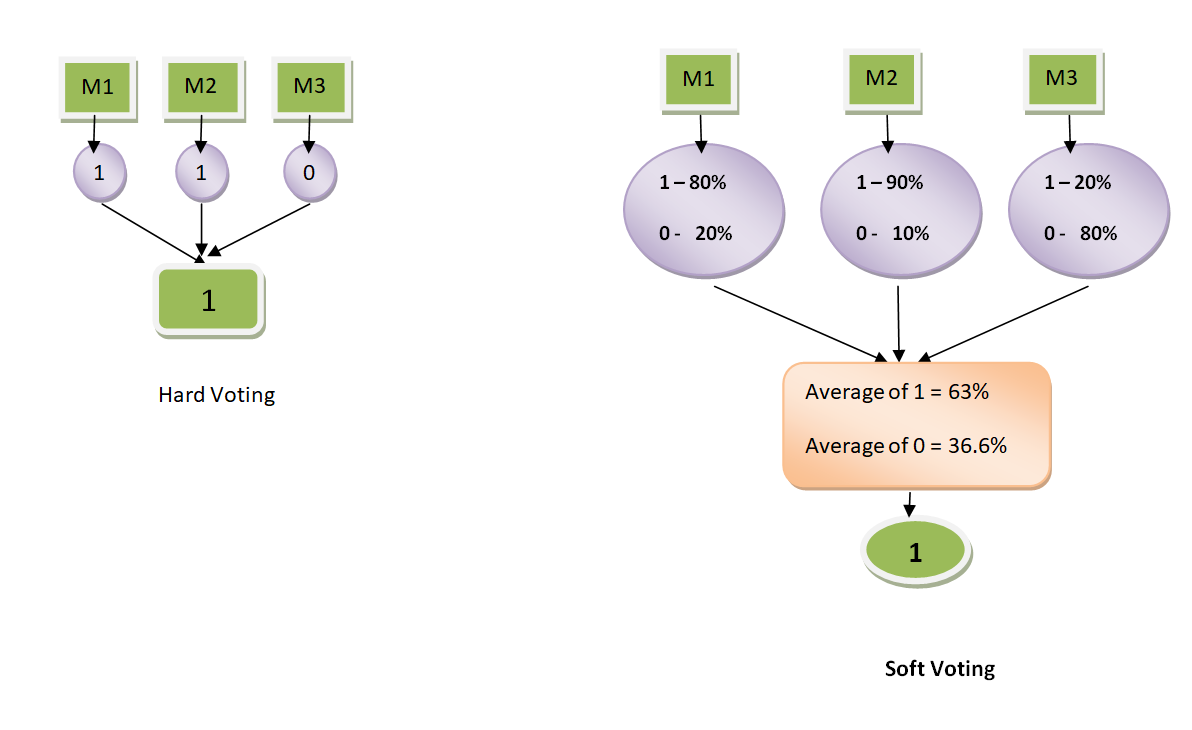

In [ ]:
clf1 = ExtraTreesClassifier(max_depth=20, min_samples_leaf=5, n_estimators=500)
clf2 = KNeighborsClassifier(n_neighbors=2)
clf3 = RandomForestClassifier(max_depth=30, max_features='log2', min_samples_leaf=5,n_estimators=700)

eclf1 = VotingClassifier(estimators=[('ExTrees', clf1),  ('KNN', clf2),('RF',clf3)], voting='soft')
eclf1.fit(X_train_over,Y_train_over)
predictions = eclf1.predict(X_test)

print('Testing data soft vote result : ')
print(prediction_result(y_test, predictions))

eclf2 = VotingClassifier(estimators=[('ExTrees', clf1),('KNN', clf2),('RF',clf3)], voting='hard')
eclf2.fit(X_train_over, Y_train_over)
predictions = eclf2.predict(X_test)
print('Testing data hard vote result : ')
print(prediction_result(y_test, predictions))

Testing data soft vote result : 
AUC :  0.6851942142044531
confusion_matrix
[[262  31]
 [ 11  10]]
              precision    recall  f1-score   support

           0       0.96      0.89      0.93       293
           1       0.24      0.48      0.32        21

    accuracy                           0.87       314
   macro avg       0.60      0.69      0.62       314
weighted avg       0.91      0.87      0.89       314

Testing data hard vote result : 
AUC :  0.5221030391678856
confusion_matrix
[[292   1]
 [ 20   1]]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       293
           1       0.50      0.05      0.09        21

    accuracy                           0.93       314
   macro avg       0.72      0.52      0.53       314
weighted avg       0.91      0.93      0.91       314



In [ ]:
clf1 = LogisticRegression(C=1000, class_weight='balanced', max_iter=1000)
clf2 = KNeighborsClassifier(n_neighbors=2)
clf3 = RandomForestClassifier(max_depth=30, max_features='log2', min_samples_leaf=5,n_estimators=700)
clf4 = ExtraTreesClassifier(max_depth=20, min_samples_leaf=5, n_estimators=500)
clf5 = lgb.LGBMClassifier(feature_fraction =0.6, learning_rate =0.025, max_depth=12,min_child_sample=20, n_estimators=1000)

eclf1 = VotingClassifier(estimators=[('LR', clf1),  ('KNN', clf2),('RF',clf3),('ExTrees',clf4),('LGBM',clf5)], voting='soft')
eclf1.fit(X_train_over,Y_train_over)
predictions = eclf1.predict(X_test)

print('Testing data soft vote result : ')
print(prediction_result(y_test, predictions))

eclf2 = VotingClassifier(estimators=[('LR', clf1),('KNN', clf2),('RF',clf3),('ExTrees',clf4),('LGBM',clf5)], voting='hard')
eclf2.fit(X_train_over, Y_train_over)
predictions = eclf2.predict(X_test)
print('Testing data hard vote result : ')
print(prediction_result(y_test, predictions))

[LightGBM] [Warning] Unknown parameter: min_child_sample
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
Testing data soft vote result : 
AUC :  0.6734113440598083
confusion_matrix
[[283  10]
 [ 13   8]]
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       293
           1       0.44      0.38      0.41        21

    accuracy                           0.93       314
   macro avg       0.70      0.67      0.69       314
weighted avg       0.92      0.93      0.92       314

[LightGBM] [Warning] Unknown parameter: min_child_sample
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
Testing data hard vote result : 
AUC :  0.5221030391678856
confusion_matrix
[[292   1]
 [ 20   1]]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       293
    

## Results
* In the original test data, using five classifiers (Extra Trees, Random Forest, Light GBM, K-Nearest Classifier, Logistic Regression) for soft voting ensemble results, the recall rate of failure classes reached **38%**, and the prediction accuracy rate reached **93%**.

* In the original test data, using three classifiers (Extra Trees, Random Forest, K-Nearest Classifier) for soft voting ensemble results, the recall rate of failure classes reached **48%**, and the prediction accuracy rate reached **87%**.

* In imbalanced data, the recall rate of minority class is more important , so the **best model** is using three  classifier for soft voting ensemble